In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
import json
import os
import matplotlib.pyplot as plt

In [2]:
home = Path.home()
data_path = os.path.join(home, "OneDrive", "Documents", "GitHub", "sodium-ion-batteries", "data_annotated", "annotated_data.json")

In [3]:
# === Step 1: Prepare Data ===
texts = []
labels = []
with open(data_path, "r", encoding='utf-8') as file:
    data = json.load(file)
    texts = data["text"]
    labels = data["label"]

# Map labels to integers
# label_mapping = {"Positive": 0, "Neutral": 1, "Negative": 2}
# numerical_labels = [label_mapping[label] for label in labels]
numerical_labels = labels

In [4]:
# === Step 2: Tokenize Data ===
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
max_length = 128

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, numerical_labels, test_size=0.2, random_state=42
)

# Tokenize texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt")

In [5]:
# === Step 3: Create PyTorch Dataset ===
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [6]:
# === Step 4: Load Pre-trained BERT Model ===
# num_labels = len(label_mapping)
num_labels = 2
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# === Step 5: Define Optimizer and Scheduler ===
optimizer = AdamW(model.parameters(), lr=2e-5)

# Define a learning rate scheduler
num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

C:\Users\Subways-Sun\AppData\Roaming\Python\Python310\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
# === Step 6: Training Loop with Metrics Tracking ===
device = torch.device("cuda")
model.to(device)

# Metrics tracking
train_losses = []
val_losses = []
val_accuracies = []

epochs = 7
for epoch in range(epochs):
    # Training
    model.train()
    loop = tqdm(train_loader, leave=True)
    total_train_loss = 0
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

    # Track average training loss
    train_loss = total_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            total_val_loss += outputs.loss.item()
            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == labels).sum().item()

    # Track validation loss and accuracy
    val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct / len(val_dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\Subways-Sun\AppData\Local\Temp\ipykernel_26468\3373058483.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 0: 100%|██████████| 5/5 [00:00<00:00,  7.41it/s, loss=0.346]


Epoch 0: Train Loss = 0.4714, Val Loss = 0.5089, Val Accuracy = 0.8000


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 10.67it/s, loss=0.402]


Epoch 1: Train Loss = 0.3971, Val Loss = 0.5204, Val Accuracy = 0.8000


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 10.65it/s, loss=0.448]


Epoch 2: Train Loss = 0.3534, Val Loss = 0.5252, Val Accuracy = 0.8000


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 10.51it/s, loss=0.353]


Epoch 3: Train Loss = 0.3635, Val Loss = 0.5252, Val Accuracy = 0.8000


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 10.75it/s, loss=0.471]


Epoch 4: Train Loss = 0.3618, Val Loss = 0.5252, Val Accuracy = 0.8000


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 10.83it/s, loss=0.17] 


Epoch 5: Train Loss = 0.3607, Val Loss = 0.5252, Val Accuracy = 0.8000


Epoch 6: 100%|██████████| 5/5 [00:00<00:00, 10.87it/s, loss=0.466]

Epoch 6: Train Loss = 0.3551, Val Loss = 0.5252, Val Accuracy = 0.8000


In [ ]:
# === Step 7: Save the Model ===
model.save_pretrained("fine_tuned_bert")
tokenizer.save_pretrained("fine_tuned_bert")

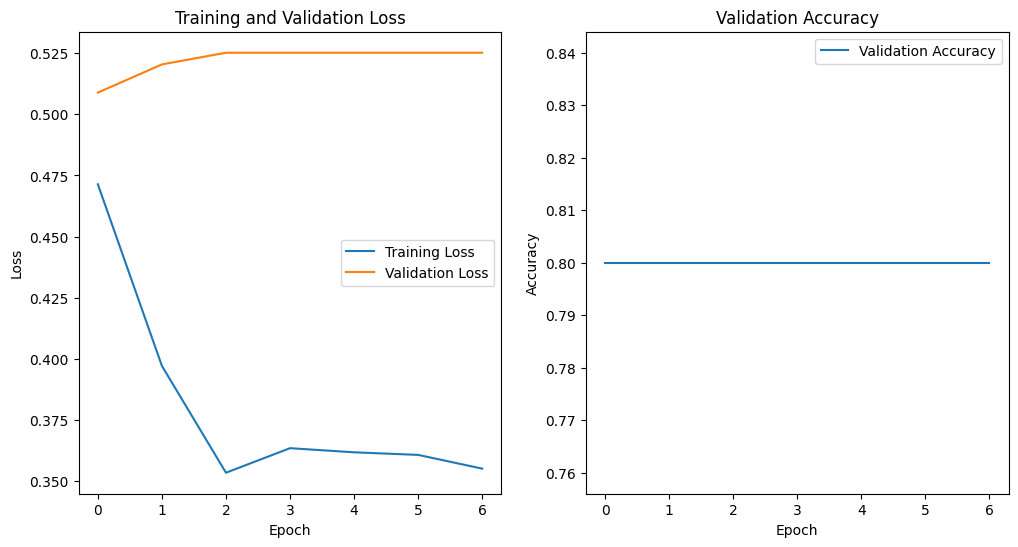

In [9]:
# === Step 8: Visualize Metrics ===
epochs_range = range(epochs)

plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.show()
